# Preliminaries

- Import all the packages that are needed for the work in this notebook, as well as a list with the size of the problems to be computed.
- Write a function for graphingexecution time versus problem size for indiviual methods

In [1]:
import numpy as np
import time
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from scipy import stats
import cupy as cp
import cupyx

sizes = [10, 100, 1000, 10000, 60000]

In [12]:
def plot(np_file,):
    ''' Load data '''
    data = np.load(np_file)
    
    ''' Cleanse running time data '''
    time_min = 1e-8
    data[:,1] = np.maximum(data[:,1], time_min)

    ''' Plot '''
    fig,ax = plt.subplots(1,2)
    ax[0].plot(data[:,0],data[:,1], c='k')
    ax[0].set_xlabel('Number of rows (n)')
    ax[0].set_ylabel('Execution Time (seconds)')
    ax[1].plot(np.log(data[:,0]),np.log(data[:,1]), c='k')
    ax[1].set_xlabel('Ln(Number of rows)')
    ax[1].set_ylabel('Ln(Execution Time)')
    fig.set_size_inches(10,4)
    fig.tight_layout()
    fig.savefig(np_file + '.jpg', dpi=600)
    plt.show()

    ''' Linear Regression '''
    print(stats.linregress(np.log(data[:,0]),np.log(data[:,1])))

# <code>numpy</code> (nonparallel) Code

## <code>for</code> Loops

In [17]:
time_for = []
for s in sizes[:3]:
    ''' Load data '''
    p = np.load(f'data/mnist1_{s}.npy').astype(np.float64)
    q = np.load(f'data/mnist2_{s}.npy').astype(np.float64)
    assert p.shape[0] == q.shape[0]
    assert p.shape[1] == 784
    assert q.shape[1] == 784

    n = p.shape[0]
    pixels = p.shape[1]
    
    ''' Compute distances '''
    start = time.time()
    result = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            sum_sq = 0.0
            for k in range(pixels):
                sum_sq += (q[i][k] - p[j][k])**2
            result[i][j] = np.sqrt(sum_sq)

    time_for.append((s,float(time.time() - start)))
    print('Exec. time: %s for %sx%s' % (str(float(time.time() - start)), str(n), str(n)))

np.save('results/time_for.npy', np.array(time_for))

Exec. time: 0.06510329246520996 for 10x10
Exec. time: 6.4061360359191895 for 100x100
Exec. time: 623.3694369792938 for 1000x1000


In [13]:
np.load('results/time_for.npy')

array([[1.00000000e+01, 7.09896088e-02],
       [1.00000000e+02, 6.25488520e+00],
       [1.00000000e+03, 6.45882732e+02]])

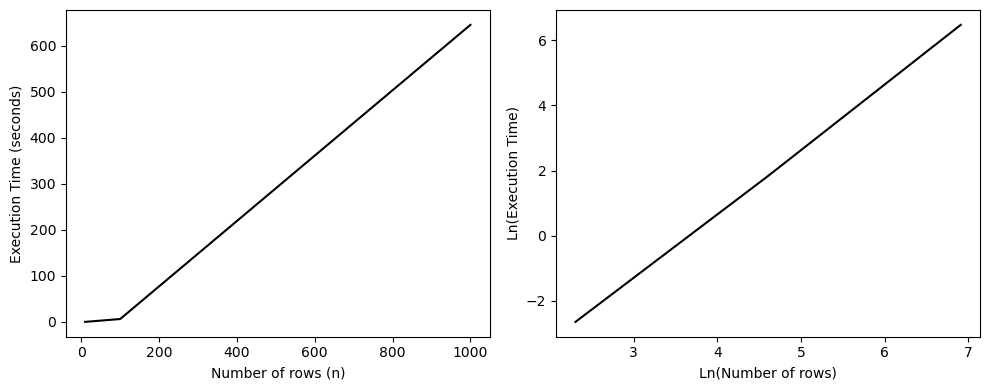

LinregressResult(slope=1.9794794455835534, intercept=-7.229586733136868, rvalue=0.9999495088245962, pvalue=0.006397417420590579, stderr=0.01989253731126122, intercept_stderr=0.09894851037688808)


In [16]:
data_file = 'results/time_for.npy'
plot(data_file)

## <code>numpy np.newaxis()</code> with Broadcasting to Avoid Loops

In [18]:
time_newaxis = []
for s in sizes[:3]: # memory exceeded for larger problems
    ''' Load data '''
    p = np.load(f'data/mnist1_{s}.npy').astype(np.float64)
    q = np.load(f'data/mnist2_{s}.npy').astype(np.float64)
    assert p.shape[0] == q.shape[0]
    assert p.shape[1] == 784
    assert q.shape[1] == 784

    n = p.shape[0]
    pixels = p.shape[1]
    
    ''' Compute distances '''
    start = time.time()
    result = np.sqrt(((q[:, np.newaxis, :] - p)**2).sum(axis=2))

    time_newaxis.append((s,float(time.time() - start)))
    print('Exec. time: %s for %sx%s' % (str(float(time.time() - start)), str(n), str(n)))

np.save('results/time_newaxis.npy', np.array(time_newaxis))

Exec. time: 0.0 for 10x10
Exec. time: 0.06254076957702637 for 100x100
Exec. time: 4.186593055725098 for 1000x1000


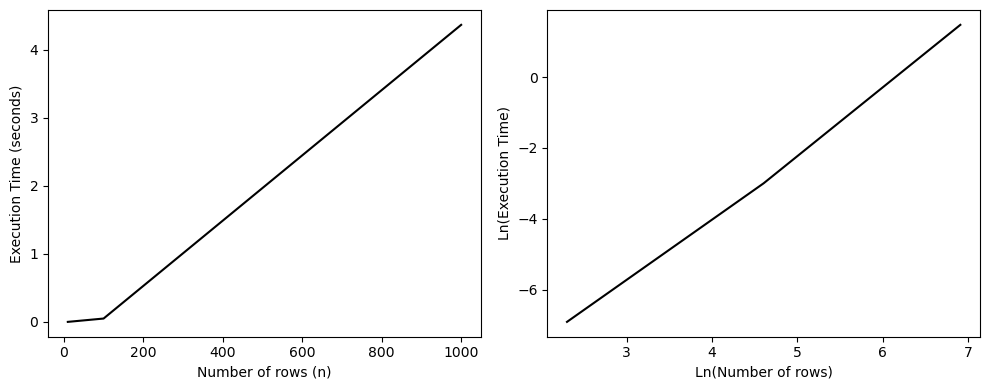

LinregressResult(slope=1.820541006056468, intercept=-11.195862012928895, rvalue=0.9992590672580873, pvalue=0.024508195333819614, stderr=0.07012070894099078, intercept_stderr=0.34879108621073496)


In [19]:
data_file = 'results/time_newaxis.npy'
plot(data_file)

## <code>np.linalg.norm()</code>

In [19]:
time_linalg = []
for s in sizes[:3]:  # memory exceeded for larger problems
    ''' Load data '''
    p = np.load(f'data/mnist1_{s}.npy').astype(np.float64)
    q = np.load(f'data/mnist2_{s}.npy').astype(np.float64)
    assert p.shape[0] == q.shape[0]
    assert p.shape[1] == 784
    assert q.shape[1] == 784

    n = p.shape[0]
    pixels = p.shape[1]
    
    ''' Compute distances '''
    start = time.time()
    result = np.linalg.norm(q[:, np.newaxis, :] - p, axis=2)

    time_linalg.append((s,float(time.time() - start)))
    print('Exec. time: %s for %sx%s' % (str(float(time.time() - start)), str(n), str(n)))

np.save('results/time_linalg.npy', np.array(time_linalg))

Exec. time: 0.0 for 10x10
Exec. time: 0.06254720687866211 for 100x100
Exec. time: 4.452097654342651 for 1000x1000


Code revised for memory issue.

In [34]:
time_linalg2 = []
for s in sizes[:4]:  # time exceeded for larger problems
    ''' Load data '''
    p = np.load(f'data/mnist1_{s}.npy').astype(np.float64)
    q = np.load(f'data/mnist2_{s}.npy').astype(np.float64)
    assert p.shape[0] == q.shape[0]
    assert p.shape[1] == 784
    assert q.shape[1] == 784

    n = p.shape[0]
    pixels = p.shape[1]
    if q.shape[0]==10000:
        qq = np.split(q,100)
    elif q.shape[0]==60000:
        qq = np.split(q,3000)
    else:
        qq = [q.copy()]
    del q
    
    ''' Compute distances '''
    start = time.time()
    result = []
    for q in qq:
        result.append(np.linalg.norm(q[:, np.newaxis, :] - p, axis=2))
        print('.', end='')

    time_linalg2.append((s,float(time.time() - start)))
    print('\nExec. time: %s for %sx%s' % (str(float(time.time() - start)), str(n), str(n)))

np.save('results/time_linalg2.npy', np.array(time_linalg2))

.
Exec. time: 0.03690195083618164 for 10x10
.
Exec. time: 0.04787325859069824 for 100x100
.
Exec. time: 4.561360597610474 for 1000x1000
....................................................................................................
Exec. time: 478.1154372692108 for 10000x10000


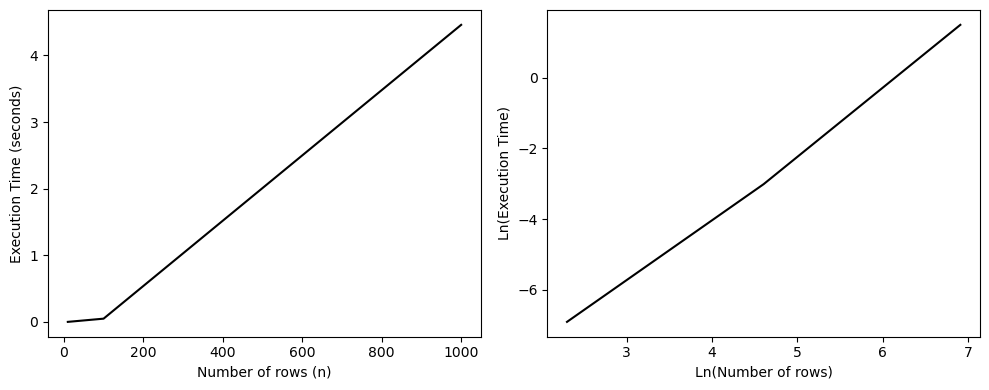

LinregressResult(slope=1.8251499523413641, intercept=-11.214579406744699, rvalue=0.9991251010802946, pvalue=0.026632119427003685, stderr=0.07639722920482307, intercept_stderr=0.3800114539666863)


In [22]:
data_file = 'results/time_linalg.npy'
plot(data_file)

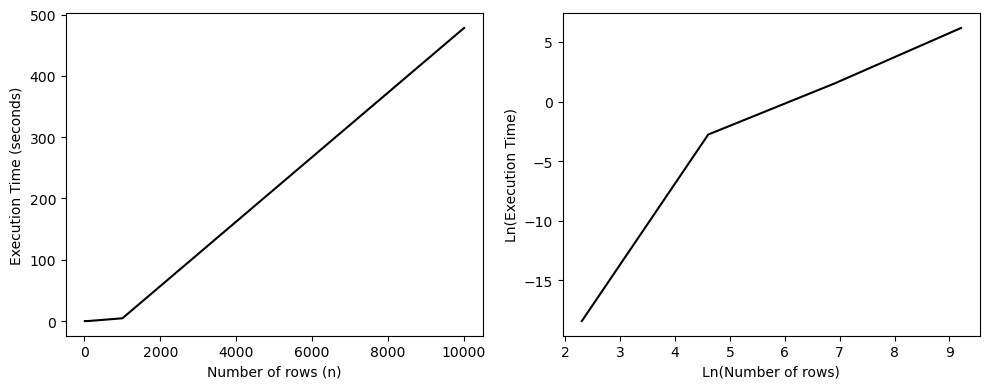

LinregressResult(slope=3.390148478509554, intercept=-22.89152369454355, rvalue=0.9441634752091121, pvalue=0.055836524790887875, stderr=0.8365311277219833, intercept_stderr=5.275072419762361)


In [45]:
data1 = np.load('results/time_linalg.npy')
data2 = np.load('results/time_linalg2.npy')
data = np.concatenate((data1[:2],data2[2:]))
np.save('results/time_linalg_alt.npy',data)
plot('results/time_linalg_alt.npy')

## <code>cdist()</code>

In [20]:
time_cdist = []
for s in sizes[:4]:
    ''' Load data '''
    p = np.load(f'data/mnist1_{s}.npy').astype(np.float64)
    q = np.load(f'data/mnist2_{s}.npy').astype(np.float64)
    assert p.shape[0] == q.shape[0]
    assert p.shape[1] == 784
    assert q.shape[1] == 784

    n = p.shape[0]
    pixels = p.shape[1]
    
    ''' Compute distances '''
    start = time.time()
    result = cdist(q,p)

    time_cdist.append((s,float(time.time() - start)))
    print('Exec. time: %s for %sx%s' % (str(float(time.time() - start)), str(n), str(n)))

np.save('results/time_cdist.npy', np.array(time_cdist))

Exec. time: 0.0 for 10x10
Exec. time: 0.0 for 100x100
Exec. time: 0.4529547691345215 for 1000x1000
Exec. time: 51.425583362579346 for 10000x10000


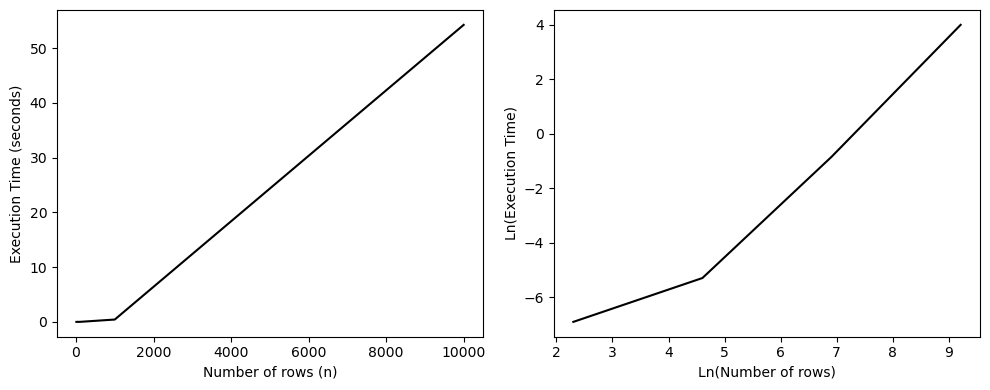

LinregressResult(slope=1.6140684151736788, intercept=-11.558808234333524, rvalue=0.979545863913857, pvalue=0.020454136086142993, stderr=0.23445285240396674, intercept_stderr=1.4784336583130826)


In [24]:
data_file = 'results/time_cdist.npy'
plot(data_file)

## <code>np.einsum()</code>

In [21]:
time_einsum = []
for s in sizes: 
    ''' Load data '''
    p = np.load(f'data/mnist1_{s}.npy').astype(np.float64)
    q = np.load(f'data/mnist2_{s}.npy').astype(np.float64)
    assert p.shape[0] == q.shape[0]
    assert p.shape[1] == 784
    assert q.shape[1] == 784

    n = p.shape[0]
    pixels = p.shape[1]
    
    ''' Compute distances '''
    start = time.time()
    result_ein = np.sqrt(np.einsum('ij,ij->i',q,q)[:,np.newaxis] - 2*q@p.T + np.einsum('ij,ij->i',p,p))

    time_einsum.append((s,float(time.time() - start)))
    print('Exec. time: %s for %sx%s' % (str(float(time.time() - start)), str(n), str(n)))

np.save('results/time_einsum.npy', np.array(time_einsum))

Exec. time: 0.0 for 10x10
Exec. time: 0.0 for 100x100
Exec. time: 0.015619754791259766 for 1000x1000
Exec. time: 1.2029101848602295 for 10000x10000
Exec. time: 54.69050693511963 for 60000x60000


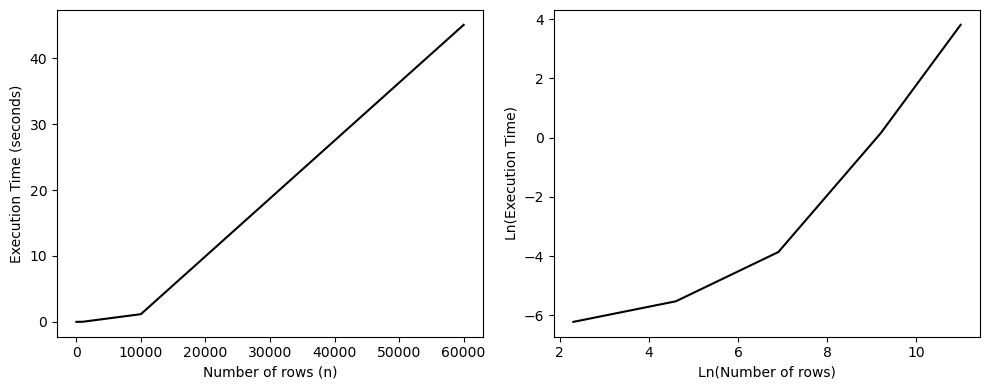

LinregressResult(slope=1.1565796764646579, intercept=-10.19899346749501, rvalue=0.9526115976355098, pvalue=0.012295057886269813, stderr=0.21322740942674337, intercept_stderr=1.5959416922175829)


In [26]:
data_file = 'results/time_einsum.npy'
plot(data_file)

If memory limitations are exceeded in the distance computation with <code>np.einsum()</code> above, then the computations could be compartmentalized and, further, the data chunked for the matrix cross-multiplication term, as is shown below to reduce the memory footprint.  

In [40]:
''' Load data '''
size = 60000
p = np.load(f'data/mnist1_{size}.npy').astype(np.float32)
q = np.load(f'data/mnist2_{size}.npy').astype(np.float32)
assert p.shape[0] == q.shape[0]
assert p.shape[1] == 784
assert q.shape[1] == 784

n = p.shape[0]
pixels = p.shape[1]

''' Set up empty list and split data '''
qx = np.split(q,20)
result = []
start = time.time()

''' Compute cross-multiplication term '''
for qxx in qx:
    result.append(np.einsum('ij,jk->ik',-2*qxx,p.T))
    print('.', end='')
del qx
print()
result = np.vstack(result)

''' Square images in q and delete data'''
result += np.einsum('ij,ij->i',q,q)[:,np.newaxis]
del q

''' Square images in p and delete data'''
result += np.einsum('ij,ij->i',p,p) 
del p

''' Take square root '''
result = np.sqrt(result)

''' Print results '''
print(f'Exec. time: {time.time() - start} for {n}x{n}' )
print(result[0,:5])

....................
Exec. time: 926.5729475021362 for 60000x60000
[10.056426 10.385668 10.338493  8.06555   9.703679]


# GPU Parallel Processing with <code>cupy</code>

## <code>cupy cp.newaxis()</code> with Broadcasting to Avoid Loops

In [33]:
time_newaxis_cp = []
for s in sizes[:3]: # memory exceeded for larger problems
    ''' Load data '''
    p = cp.load(f'data/mnist1_{s}.npy').astype(cp.float64)
    q = cp.load(f'data/mnist2_{s}.npy').astype(cp.float64)
    assert p.shape[0] == q.shape[0]
    assert p.shape[1] == 784
    assert q.shape[1] == 784

    n = p.shape[0]
    pixels = p.shape[1]
    
    ''' Compute distances '''
    start = time.time()
    result = cp.sqrt(((q[:, np.newaxis, :] - p)**2).sum(axis=2))

    time_newaxis_cp.append((s,float(time.time() - start)))
    print('Exec. time: %s for %sx%s' % (str(float(time.time() - start)), str(n), str(n)))

np.save('results/time_newaxis_cp.npy', np.array(time_newaxis))

Exec. time: 0.0 for 10x10
Exec. time: 0.0 for 100x100
Exec. time: 0.009972095489501953 for 1000x1000


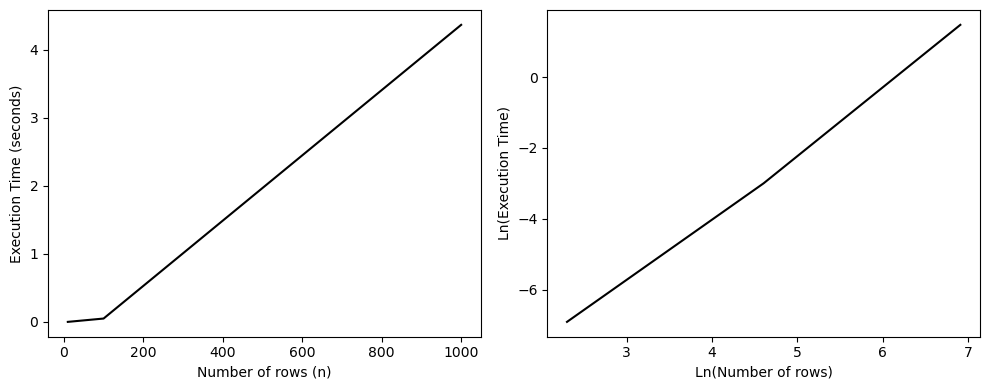

LinregressResult(slope=1.820541006056468, intercept=-11.195862012928895, rvalue=0.9992590672580873, pvalue=0.024508195333819614, stderr=0.07012070894099078, intercept_stderr=0.34879108621073496)


In [34]:
data_file = 'results/time_newaxis_cp.npy'
plot(data_file)

## <code>cp.linalg.norm()</code>

In [4]:
time_linalg_cp = []
for s in sizes[:3]:  # memory exceeded for larger problems
    ''' Load data '''
    p = cp.load(f'data/mnist1_{s}.npy').astype(cp.float64)
    q = cp.load(f'data/mnist2_{s}.npy').astype(cp.float64)
    assert p.shape[0] == q.shape[0]
    assert p.shape[1] == 784
    assert q.shape[1] == 784

    n = p.shape[0]
    pixels = p.shape[1]
    
    ''' Compute distances '''
    start = time.time()
    result = cp.linalg.norm(q[:, np.newaxis, :] - p, axis=2)

    time_linalg_cp.append((s,float(time.time() - start)))
    print('Exec. time: %s for %sx%s' % (str(float(time.time() - start)), str(n), str(n)))

np.save('results/time_linalg_cp.npy', np.array(time_linalg_cp))

Exec. time: 0.0 for 10x10
Exec. time: 0.0 for 100x100
Exec. time: 0.0009374618530273438 for 1000x1000


In [11]:
np.load('results/time_linalg_cp.npy')

array([[1.00000000e+01, 0.00000000e+00],
       [1.00000000e+02, 0.00000000e+00],
       [1.00000000e+03, 9.37461853e-04]])

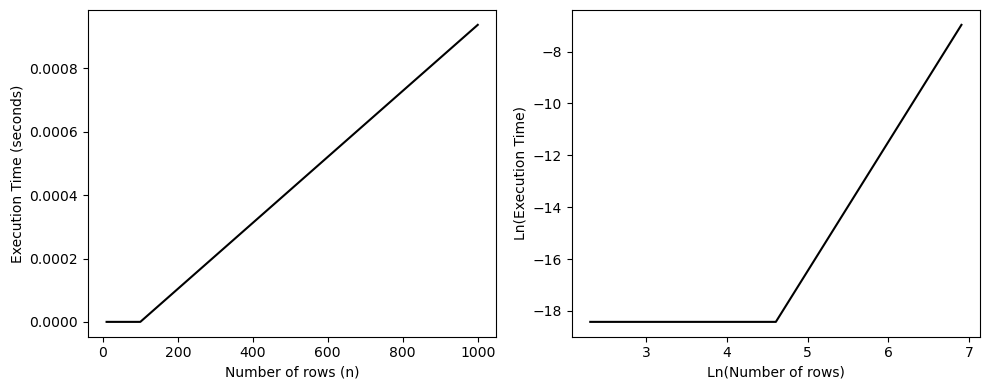

LinregressResult(slope=2.4859768022762565, intercept=-26.052911579219455, rvalue=0.8660254037844385, pvalue=0.3333333333333334, stderr=1.4352793759933629, intercept_stderr=7.139298220585239)


In [13]:
data_file = 'results/time_linalg_cp.npy'
plot(data_file)

## <code>np.einsum()</code>

In [15]:
time_einsum_cp = []
for s in sizes: #[:4]:
    ''' Load data '''
    p = cp.load(f'data/mnist1_{s}.npy').astype(cp.float16)
    q = cp.load(f'data/mnist2_{s}.npy').astype(cp.float16)
    assert p.shape[0] == q.shape[0]
    assert p.shape[1] == 784
    assert q.shape[1] == 784

    n = p.shape[0]
    pixels = p.shape[1]
    
    ''' Compute distances '''
    start = time.time()
    result_ein = cp.sqrt(np.einsum('ij,ij->i',q,q)[:,np.newaxis] - 2*q@p.T + np.einsum('ij,ij->i',p,p))

    time_einsum_cp.append((s,float(time.time() - start)))
    print('Exec. time: %s for %sx%s' % (str(float(time.time() - start)), str(n), str(n)))

np.save('results/time_einsum_cp.npy', np.array(time_einsum_cp))

Exec. time: 0.001001119613647461 for 10x10
Exec. time: 0.0009970664978027344 for 100x100
Exec. time: 0.0 for 1000x1000
Exec. time: 0.000997304916381836 for 10000x10000
Exec. time: 0.0 for 60000x60000


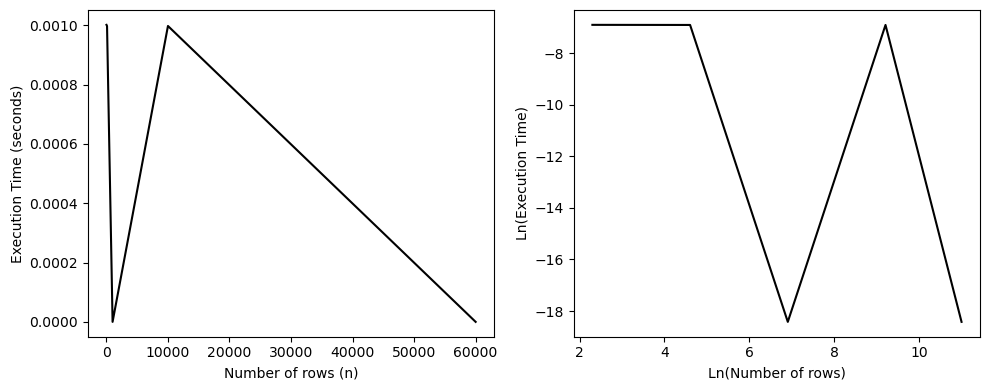

LinregressResult(slope=-1.0200427055808778, intercept=-4.571836380554959, rvalue=-0.5634715801210746, pvalue=0.32258191084522164, stderr=0.8634495512536728, intercept_stderr=6.46265478569129)


In [16]:
data_file = 'results/time_einsum_cp.npy'
plot(data_file)

If the GPU memory limitations are exceeded in the distance computation with <code>cp.einsum()</code> above, then the computations could be compartmentalized and, further, the data chunked for the matrix cross-multiplication term, as is shown below to reduce the memory footprint.  This approach succeeded on a GPU with 28GB of memory.

In [ ]:
''' Load data '''
size = 60000
p = cp.load(f'data/mnist1_{size}.npy').astype(cp.float16)
q = cp.load(f'data/mnist2_{size}.npy').astype(cp.float16)
assert p.shape[0] == q.shape[0]
assert p.shape[1] == 784
assert q.shape[1] == 784

n = p.shape[0]
pixels = p.shape[1]

''' Set up empty list and split data '''
qx = cp.split(q,20)
result = []
start = time.time()

''' Compute cross-multiplication term '''
for qxx in qx:
    result.append(cp.einsum('ij,jk->ik',-2*qxx,p.T))
del qx
result = cp.vstack(result)

''' Square images in q and delete data'''
result += cp.einsum('ij,ij->i',q,q)[:,cp.newaxis]
del q

''' Square images in p and delete data'''
result += cp.einsum('ij,ij->i',p,p) 
del p

''' Take square root '''
result = cp.sqrt(result)

''' Print results '''
print(f'Exec. time: {time.time() - start} for {n}x{n}' )
print(result[0,:5])

# Results

## <code>numpy</code> Results

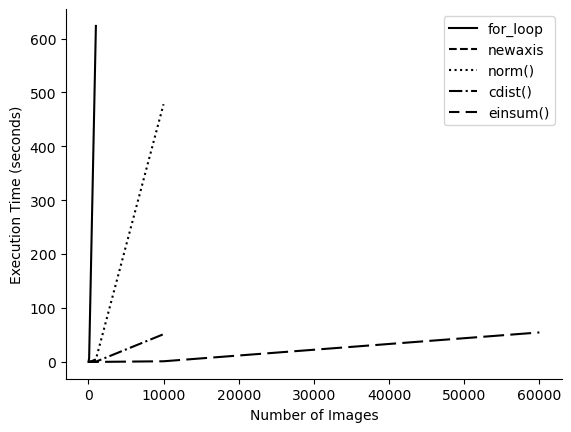

In [42]:
files = ['results/time_for.npy', 'results/time_newaxis.npy', 
         'results/time_linalg2.npy', 'results/time_cdist.npy', 'results/time_einsum.npy']
label = ['for_loop', 'newaxis', 'norm()', 'cdist()', 'einsum()']
linestyles = ['solid', 'dashed', 'dotted', 'dashdot', (5,(10,3))]

fig,ax = plt.subplots()
for i,file in enumerate(files):
    data = np.load(file)
    ax.plot(data[:,0], data[:,1], label=label[i], c='k', linestyle=linestyles[i])
    ax.set_xlabel('Number of Images')
    ax.set_ylabel('Execution Time (seconds)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
ax.legend()
plt.show()